<a href="https://colab.research.google.com/github/rickydubey/mlProjects/blob/master/fashionClassificationUsingCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Name : Classification Model for Clothing Items using FASHION MNIST datasets.

Contributor : *`Aman Kumar`*

College : National Institute Of Science And Technology, Berhampur

#***Building Classification Model For Clothing Items using CNN***

We are going to build and train a **Neural Network** to classify images of different clothing, like sneakers, shirts etc.

##*`Installing tensorflow Datasets`*


In [ ]:
!pip install -U tensorflow_datasets

##*`Importing Libraries`*

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

##*`Data Loading`*

We will be using fashion_mnist dataset, contains 70,000 grayscale images of different clothing items. Each image here is of (28 X 28) array pixels, ranging from [0, 255].

Dataset is divided into two parts -
1. Train Data (60,000 of Original Dataset)
2. Test Data (Rest 10,000 of Original Dataset)






In [3]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
train_dataset = dataset['train']
test_dataset = dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJN8ABN/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJN8ABN/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


Labels assigned to images are from range [0, 9] discribing different items.
<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Our prediction output will be a numeric value representing particular label. So, we need class_name list containg all category names.

In [5]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

##*`Data Preprocessing`*

We need to normalize our image pixel value, as they are varing in range of [0, 255].

In [6]:
def normalize(images, lables):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, lables

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

In [7]:
# This is to make our training faster, as our image data are going to be loaded from disk
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

##*`Exploring Dataset`*

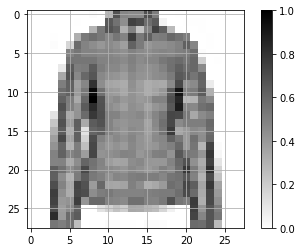

In [8]:
# displaying single image
for image, lable in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# plotting image
plt.figure()
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.grid('off')
plt.show()

Displaying 25 images from our dataset with corresponding labels.

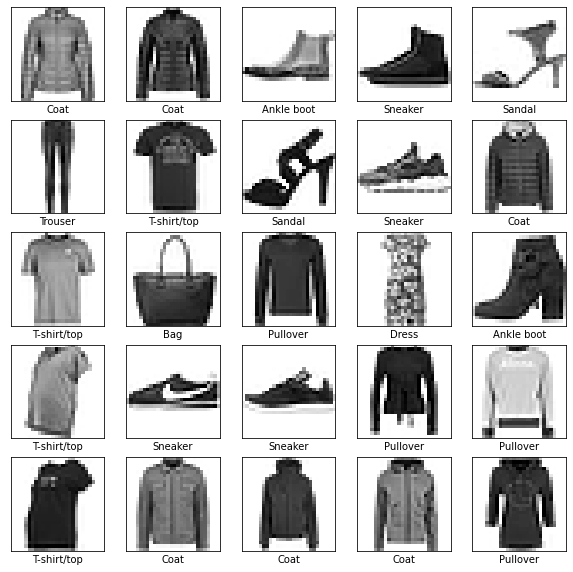

In [9]:
plt.figure(figsize = (10, 10))
i = 0
for (image, lable) in test_dataset.take(25):
  image = image.numpy().reshape((28, 28))
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')
  plt.imshow(image, cmap = plt.cm.binary)
  plt.xlabel(class_name[lable])
  i += 1
plt.show()

##*`Model Building`*


For our training purpose we are going with 2 Output Layers and 2 Convolution Layer as
* Layer 0 : Input Layer - Convolution Layer 1
* Layer 1 : Max Pooling of Layer 0
* Layer 2 : Convolution Layer 2
* Layer 3 : Max Pooling of Layer 2
* Layer 4 : Flateening Layer
* Layer 5 : Output Layer 1 - # of nodes = 128
* Layer 6 : Output Layer 2 - # of nodes = 10



In [10]:
l0 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = tf.nn.relu, input_shape = (28, 28, 1)) # input layer
l1 = tf.keras.layers.MaxPooling2D((2, 2), strides = 2) # max pooling layer 0 i.e. reducing image dimentionality
l2 = tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = tf.nn.relu) # convolution layer 2
l3 = tf.keras.layers.MaxPooling2D((2, 2), strides = 2) # max pooling layer 2 i.e. reducing image dimentionality
l4 = tf.keras.layers.Flatten() # flattening image into vector
l5 = tf.keras.layers.Dense(units = 128, activation = tf.nn.relu) #Output Layer 1
l6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.softmax) #Output Layer 2
model = tf.keras.Sequential([l0, l1, l2, l3, l4, l5, l6])

In [11]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

##*`Model Fitting`*

In [12]:
BATCH_SIZE = 32
# dataset.shuffle(60000) randomizes the order of examples
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [13]:
model.fit(train_dataset, epochs = 10, steps_per_epoch = math.ceil(num_test_examples / BATCH_SIZE))

Epoch 1/10
313/313 [==============================] - 1s 3ms/step - loss: 0.6399 - accuracy: 0.7691
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 0.4148 - accuracy: 0.8525
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 0.3759 - accuracy: 0.8654
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 0.3424 - accuracy: 0.8755
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 0.3163 - accuracy: 0.8853
Epoch 6/10
313/313 [==============================] - 1s 3ms/step - loss: 0.2915 - accuracy: 0.8919
Epoch 7/10
313/313 [==============================] - 1s 3ms/step - loss: 0.2781 - accuracy: 0.8980
Epoch 8/10
313/313 [==============================] - 1s 3ms/step - loss: 0.2882 - accuracy: 0.8941
Epoch 9/10
313/313 [==============================] - 1s 3ms/step - loss: 0.2700 - accuracy: 0.9037
Epoch 10/10
313/313 [==============================] - 1s 3ms/step - loss: 0.2680 - accuracy: 0.9014

##*`Accuracy Calculation`*

Using test dataset for accuracy calculation and compairing with accuracy and loss from training datasets. If the accuracy on the test dataset is smaller than the accuracy on the training dataset then we are fine and good to proceed.

In [14]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps = math.ceil(num_test_examples / BATCH_SIZE))
print("Test Accuracy : {}".format(test_accuracy))

313/313 [==============================] - 2s 6ms/step - loss: 0.2810 - accuracy: 0.9030
Test Accuracy : 0.902999997138977


##*`Prediction`*

In [15]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [16]:
predictions.shape

(32, 10)

In [17]:
print("Actual Value for Particular Image {}".format(test_labels[0]))
print("Predicted Value for that Image {}".format(np.argmax(predictions[0])))

if test_labels[0] == np.argmax(predictions[0]):
  print("-->Correct Prediction.")

Actual Value for Particular Image 4
Predicted Value for that Image 4
-->Correct Prediction.


We can graph this to look at the full set of 10 class predictions

In [18]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                100*np.max(predictions_array),
                                class_name[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

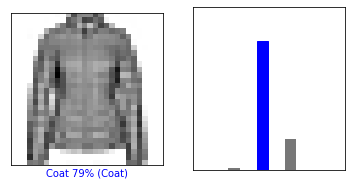

In [19]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

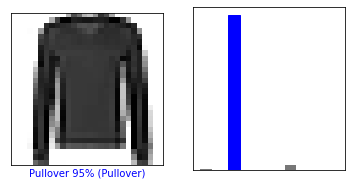

In [20]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

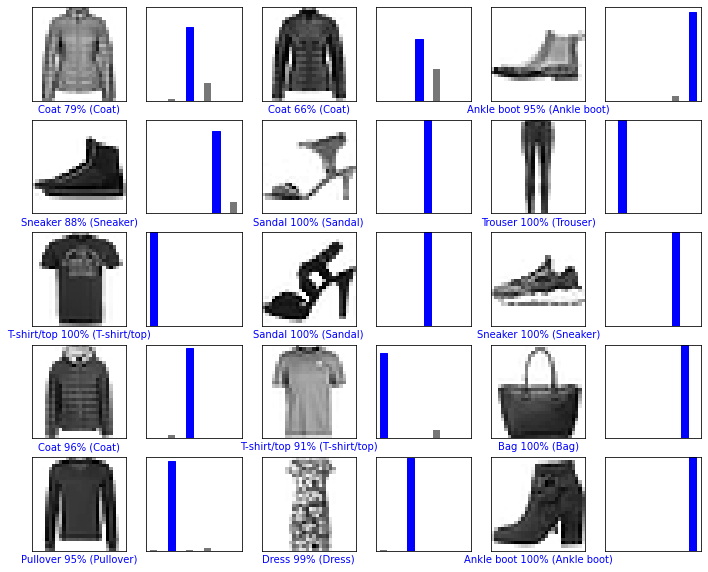

In [21]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Predicting over new Single images.

(28, 28, 1)
(1, 28, 28, 1)
4


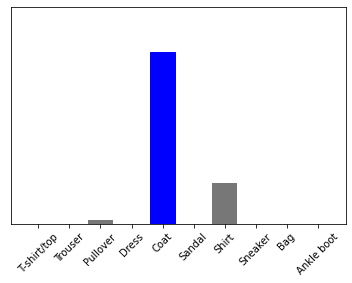

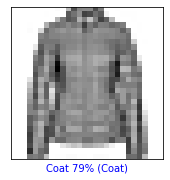

In [22]:
# Grab an image from the test dataset
img = test_images[0]
print(img.shape)
img = np.array([img])
print(img.shape)

predictions_single = model.predict(img)
print(np.argmax(predictions_single[0]))

plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_name, rotation=45)


plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(0, predictions_single, test_labels, test_images)